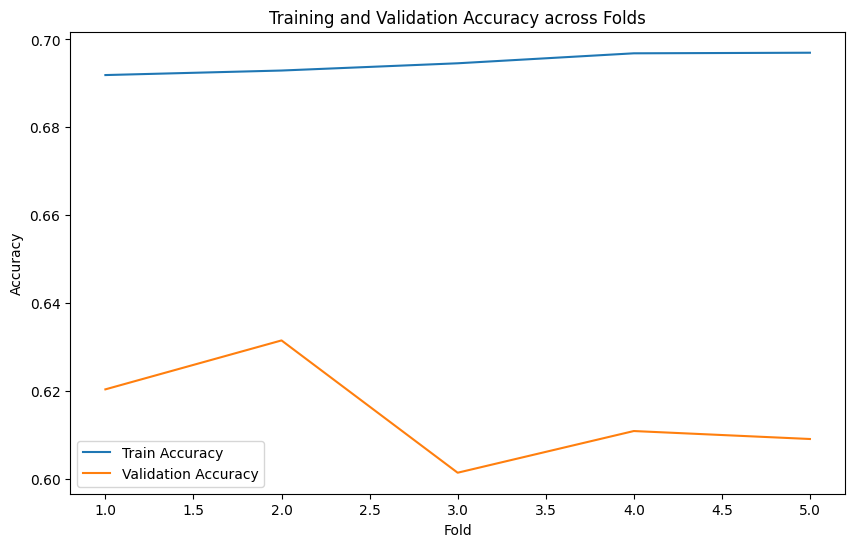

Train accuracy: 0.6850
Validation accuracy: 0.6140


In [8]:
import pandas as pd
import ast
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

# Load the data
train_data = pd.read_csv('train.csv')
valid_data = pd.read_csv('validation.csv')
test_data = pd.read_csv('test.csv')

# Name the data columns
train_data.columns = ['features', 'label']
valid_data.columns = ['features', 'label']
test_data.columns = ['features']

# Parse the string representations of features
train_data['features'] = train_data['features'].apply(lambda x: np.array(ast.literal_eval(x)))
valid_data['features'] = valid_data['features'].apply(lambda x: np.array(ast.literal_eval(x)))
test_data['features'] = test_data['features'].apply(lambda x: np.array(ast.literal_eval(x)))

# Convert features to numpy arrays
X_train = np.stack(train_data['features'].values)
X_valid = np.stack(valid_data['features'].values)
X_test = np.stack(test_data['features'].values)

# Convert labels to numpy arrays
y_train = train_data['label'].values
y_valid = valid_data['label'].values

# Handling missing values
# If there are missing values in the features, we can fill them with the mean of the respective feature
X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train))
X_valid = np.nan_to_num(X_valid, nan=np.nanmean(X_valid))
X_test = np.nan_to_num(X_test, nan=np.nanmean(X_test))

# Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Define the Gaussian Naive Bayes model
model = GaussianNB()

# Perform K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_accuracies = []
valid_accuracies = []

for train_index, valid_index in kf.split(X_train):
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]
    
    # Train the model
    model.fit(X_train_fold, y_train_fold)
    
    # Evaluate the model
    train_pred_fold = model.predict(X_train_fold)
    valid_pred_fold = model.predict(X_valid_fold)
    train_accuracy_fold = accuracy_score(y_train_fold, train_pred_fold)
    valid_accuracy_fold = accuracy_score(y_valid_fold, valid_pred_fold)
    
    train_accuracies.append(train_accuracy_fold)
    valid_accuracies.append(valid_accuracy_fold)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy across Folds')
plt.legend()
plt.show()

# Train the final model on the entire training data
model.fit(X_train, y_train)

# Evaluate the model on the validation set
train_pred = model.predict(X_train)
valid_pred = model.predict(X_valid)
train_accuracy = accuracy_score(y_train, train_pred)
valid_accuracy = accuracy_score(y_valid, valid_pred)
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Validation accuracy: {valid_accuracy:.4f}')

# Save the model
joblib.dump(model, 'model.pkl')

# Predict labels for the test set
y_pred = model.predict(X_test)

# Save the predicted labels in the same format as train.csv
test_data['predicted_label'] = y_pred
test_data[['features', 'predicted_label']].to_csv('test_predicted.csv', index=False)
